# Recommender

The following notebook contains a demonstration of the algorithms found in the thesis. All the algorithms below are executed on 100.000 elements of the movieLens dataset. The training set has 10.000 elements, and there are no updates.
The purpose of this document is to demonstrate that the algorithms do work. The size of the dataset was chosen in a way, that the results are visible, but execution doesn't take very long. For results on bigger datasets, please see the [thesis](https://github.com/ldani7492/RecommenderThesis/blob/master/thesis/Efficient%20Session-based%20Item-to-item%20Recommendation.pdf). The code included here is a simplified version, that does not require MongoDB, RabbitMQ, or the framework, only the core of the algorithms.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import time
import numpy as np
import math
import os

## Loading the dataset

In [2]:
def loadData(path):
    column_names = ["ownerId", "contentId", "rating", "timestamp"]
    opened = pd.read_table(path, encoding="latin1", sep=" ", names=column_names, engine="python")

    opened.timestamp = pd.to_datetime(opened.timestamp, unit='s')
    
    opened = opened.sort_values('timestamp')

    opened.ownerId = opened.ownerId.apply(str)
    opened.contentId = opened.contentId.apply(int)
    opened.contentId = opened.contentId.apply(str)

    return opened

In [3]:
loaded = loadData("data/dataset.csv")

Cutting the training dataset (10%)

In [4]:
train = loaded.head(10000)
test = loaded.tail(90000)
trainData = train.to_dict('records')
testData = test.to_dict('records')
itemCount = len(loaded.contentId.unique())

Creating log directory

In [5]:
if not os.path.exists('log/'):
    os.makedirs('log/')

## Common functions

In [6]:
def userIds(data):
    return data.ownerId.unique()
    
def contentIds(data):
    return data.contentId.unique()

def userRows(userIds):
    userRows = dict()

    i = 0
    for userId in userIds:
        userRows[userId] = i
        i += 1

    return userRows

def contentRows(contentIds):
    contentRows = dict()

    i = 0
    for movieId in contentIds:
        contentRows[movieId] = i
        i += 1

    return contentRows

def reverseDict(d):
    return {v:k for k,v in d.items()}

For testing:

In [7]:
def testUserToItem(data, model):
    user = data['ownerId']
    item = data['contentId']
    d = dict()
    d['rating'] = data['rating']
    d['user_found'] = user in uIds
    d['item_found'] = item in cIds
    pred = getPrediction(user,item)
    rec = getRecommendation(user,100)
    if item in rec:
        d['rank'] = rec.index(item)
    else:
        d['rank'] = itemCount
    f = open("log/"+model+".log", "a") 
    d['userId'] = user
    d['itemId'] = item
    d['prediction'] = pred
    f.write(json.dumps(d)+'\n')
    f.close()

In [8]:
def testItemToItem(data, model):
    user = data['ownerId']
    item = data['contentId']
    d = dict()
    d['user_found'] = user in lastSeen
    d['item_found'] = item in cRows
    if user in lastSeen:
        d['base_item'] = lastSeen[user]
    else:
        d['base_item'] = -1
    lastSeen[user] = item
    if item not in items:
        itemsSeen[item] = set()
    itemsSeen[item].add(user)
    if user in lastSeen and item in cRows:
        mpr = MPR(d['base_item'], item, len(items))
        d['mpr'] = mpr[0]
        d['rank'] = mpr[1]
    else:
        d['mpr'] = 1
        d['rank'] = itemCount
    f = open("log/"+model+".log", "a") 
    d['userId'] = dat['ownerId']
    d['itemId'] = dat['contentId']
    f.write(json.dumps(d)+'\n')
    f.close()

## Matrix Factorization with Stochastic Gradient Descent

### Training

Functions for the algorithm:

In [9]:
def createMatrix(loaded, userIds, contentIds, userRows, contentRows):
    M = np.zeros((len(userIds), len(contentIds)))

    for r in zip(loaded['ownerId'], loaded['contentId'], loaded['rating']):
        M[userRows[r[0]], contentRows[r[1]]] = r[2]

    return M

def normalizeByRows(M):
    u = np.zeros(M.shape[0])
    for i in range(M.shape[0]):
        m = M[i]
        elems = m[m != 0]
        if len(elems) == 0:
            u[i] = 0
        else:
            u[i] = np.mean(elems)
        mask = M[i] != 0
        M[i, mask] = np.subtract(M[i, mask], u[i])
    return u

def normalizeByColumns(M):
    i = normalizeByRows(M.transpose())
    M = M.transpose()
    return i

def restoreNormalization(P, rowAvg, columnAvg):
    P = np.add(P, columnAvg)
    P = P.transpose()
    P = np.add(P, rowAvg)
    P = P.transpose()
    return P

def fill(M, c, a, d):
    div = a/d
    base = float(math.sqrt(abs(a/d)))
    base = math.copysign(base, div)
    if c == 0:
        M.fill(base)
    else:
        M = (np.random.rand(M.shape[0],M.shape[1]) - 0.5) * 2*c + base
    return M

def getPermutation(M):
    nonzeros = np.transpose(np.nonzero(M))
    np.random.shuffle(nonzeros)
    return nonzeros

def improve(M, U, V, i, j, l):
    p = np.copy(U[i])
    V = V.transpose()
    q = np.copy(V[j])
    err = M[i,j] - np.dot(p, q)
    U[i] = p + 2*l*err*q
    V[j] = q + 2*l*err*p
    V = V.transpose()
    return 2*l*err*q

def trainMatrix(M0,l,c,d,runPerRound):
    if len(M0[M0 != 0]) == 0:
        avg = 0
    else:
        avg = np.mean(M0[M0 != 0])

    M = np.copy(M0)
    rowAvg = normalizeByRows(M)
    colAvg = normalizeByColumns(M)
    U = fill(np.zeros((M.shape[0], d)), c, avg, d)
    V = fill(np.zeros((d, M.shape[1])), c, avg, d)
    perm = getPermutation(M0)

    for n in range(runPerRound):
        for p in perm:
            improve(M, U, V, p[0], p[1], l)

    P = np.dot(U,V)
    P = restoreNormalization(P, rowAvg, colAvg)

    return (U,V,P,rowAvg,colAvg)

Training the model:

In [10]:
t0 = time.time()

uIds = userIds(train)
cIds = contentIds(train)

uRows = userRows(uIds)
cRows = contentRows(cIds)

reverseUserRows = reverseDict(uRows)
reverseContentRows = reverseDict(cRows)

M = createMatrix(train, uIds, cIds, uRows, cRows)
(U,V,P,rowAvg,colAvg) = trainMatrix(M,0.03,0.5,100,10)

t1 = time.time()
print("Training time: " + str(t1-t0))

Training time: 4.120093822479248


### Testing

Functions for testing:

In [11]:
def getPrediction(userId, itemId):
    if (userId not in uRows) or (itemId not in cRows):
        return 3
    uRow = uRows[userId]
    cRow = cRows[itemId]
    pred = P[uRow,cRow]
    if pred > 5:
        return 5
    if pred < 1:
        return 1
    return pred

In [12]:
def getRecommendation(user,k):
    if user not in uIds:
        top = globalTop()
    else:
        if user in cache:
            top = cache[user]
        else:
            itemList = P[uRows[user]]
            top = list()
            i = 0
            for p in itemList:
                top.append((reverseContentRows[i], p))
            top.sort(key=lambda rec: rec[1], reverse=True)
            cache[user] = top
    top = [x[0] for x in top]
    return top[0:k]

In [13]:
def globalTop():
    if 'top' in cache:
        return cache['top']
    else:
        colRank = list()
        for c in P.transpose():
            colRank.append(np.mean(c))
        topRanking = list()
        i = 0
        for c in colRank:
            topRanking.append((reverseContentRows[i], c))
            i += 1
        topRanking.sort(key=lambda r: r[1], reverse=True)
        cache['top'] = topRanking
        return topRanking

Testing:

In [14]:
t0 = time.time()

cache = dict()
i = 0
for dat in testData:
    testUserToItem(dat,'SGD')
    
t1 = time.time()
print(t1-t0)

104.16236209869385


### Matrix Factorization with Alternating Least Squares

### Training

Most of the functions for ALS are the same as the ones for SGD.

In [15]:
def improveRow(M, U, V, row):
    p = np.copy(U[row])
    Vt = V.transpose()
    cols = np.nonzero(M[row])[0]
    vs = Vt[cols]
    a = [[sum([Vt[col,j]*Vt[col,i] for col in cols]) for i in range(len(Vt[0]))] for j in range(len(U[0]))]
    b = [sum([M[row,col]*Vt[col,i] for col in cols]) for i in range(len(U[0]))]
    U[row] = np.linalg.lstsq(a,b)[0]
    return U

def improveCol(M, U, V, col):
    Vt = V.transpose()
    Mt = M.transpose()
    rows = np.nonzero(Mt[col])[0]
    us = U[rows]
    a = [[round(sum([U[row,i]*U[row,j] for row in rows]),100) for i in range(len(U[0]))] for j in range(len(Vt[0]))]
    b = [sum([M[row,col]*U[row,i] for row in rows]) for i in range(len(Vt[0]))]
    Vt[col] = np.linalg.lstsq(a,b)[0]
    V = Vt.transpose()
    return V

def trainMatrix(M0,c,d,runPerRound):
    if len(M0[M0 != 0]) == 0:
        avg = 0
    else:
        avg = np.mean(M0[M0 != 0])

    M = np.copy(M0)
    rowAvg = normalizeByRows(M)
    colAvg = normalizeByColumns(M)
    U = fill(np.zeros((M.shape[0], d)), c, avg, d)
    V = fill(np.zeros((d, M.shape[1])), c, avg, d)

    for n in range(runPerRound):
        for i in range(M.shape[0]):
            U = improveRow(M,U,V,i)
        for j in range(M.shape[1]):
            V = improveCol(M,U,V,j)

    P = np.dot(U,V)
    P = restoreNormalization(P, rowAvg, colAvg)

    return (U,V,P,rowAvg,colAvg)

Training the model:

In [16]:
t0 = time.time()

uIds = userIds(train)
cIds = contentIds(train)

uRows = userRows(uIds)
cRows = contentRows(cIds)

reverseUserRows = reverseDict(uRows)
reverseContentRows = reverseDict(cRows)

M = createMatrix(train, uIds, cIds, uRows, cRows)
(U,V,P,rowAvg,colAvg) = trainMatrix(M,0.5,10,3)

t1 = time.time()
print("Training time: " + str(t1-t0))

Training time: 13.83879542350769


### Testing

In [17]:
t0 = time.time()

cache = dict()
i = 0
for dat in testData:
    testUserToItem(dat,'ALS')
    
t1 = time.time()
print(t1-t0)

104.47319102287292


## k-Nearest-Neighbors

### Training

Loading movie data for similarities:

In [18]:
def loadSampleContent(path):
    column_names = ["movieId", "title", "genre"]
    items = pd.read_table(path, encoding="latin1", sep="::", names=column_names, index_col="movieId", engine="python")
    items.genre = items.genre.str.replace("|", ", ")

    for i in items.index:
        items.genre[i] = items.genre[i].split(', ')

    return items

Functions for training:

In [19]:
def createMatrix(loaded, userIds, contentIds, userRows, contentRows):
    M = np.zeros((len(userIds), len(contentIds)))

    for r in zip(loaded['ownerId'], loaded['contentId'], loaded['rating']):
        M[userRows[r[0]], contentRows[r[1]]] = r[2]

    return M

def standardDeviation(values):
    m = np.mean(values)
    s = np.sum(np.square(np.subtract(values,m)))
    return math.sqrt((1/(len(values)-1)*s))

def covariance(x,y):
    xm = np.mean(x)
    ym = np.mean(y)
    xx = np.subtract(x,xm)
    yy = np.subtract(y,ym)
    s = np.sum(np.multiply(xx,yy))
    return (1/(len(x)-1))*s

def pearson(x,y):
    sxy = covariance(x,y)
    sx = standardDeviation(x)
    sy = standardDeviation(y)
    return sxy/(sx*sy)

def initializeGenres(items):
    genres = set()

    for i in items.index:
        genres |= set(items.genre[i])

    return genres

def setItemGenres():
    itemRows = contentRows(items.index)
    itemGenres = dict()

    for g in genres:
        items[g] = 0

    genreList = items['genre'].to_dict()
    for g in genres:
        gd = items[g].to_dict()
        for k in genreList:
            gd[k] = int(g in genreList[k])
        items[g] = gd.values()

    genreMatrix = items[list(genres)].as_matrix()

    for i in items.index:
        itemGenres[str(i)] = genreMatrix[itemRows[i]]

    return itemGenres

def distanceMatrix():
    l = len(itemGenres)
    D = np.zeros([l,l])
    coords = np.array(np.meshgrid(range(l),range(l))).T.reshape(-1,2)
    for i,j in coords:
        D[i,j] = pearson(itemGenres[reverseContentRows[i]],itemGenres[reverseContentRows[j]])
    return D

def kMostSimilar(contentId,rated,k):
    rank = list()
    cRow = cRows[contentId]
    Dt = D.transpose()
    contentDistances = Dt[cRow][0:cRow]
    contentDistances = np.append(contentDistances,D[cRow][cRow:D.shape[0]])
    for v in rated:
        if v != cRow:
            rank.append((str(reverseContentRows[v]), contentDistances[v]))
    rank.sort(key=lambda r: r[1], reverse=True)
    rank = rank[0:k]
    return rank

def similarRated(userId, contentId,k):
    userRow = M[uRows[userId]]
    nonzero = np.nonzero(userRow)[0]
    if len(nonzero) == 0:
        return []
    movies = kMostSimilar(contentId,nonzero,k)
    return movies

def kNN(userId, contentId,k):
    movies = similarRated(userId, contentId,k)
    if (len(movies) == 0):
        knn = 0
    else:
        userRow = M[uRows[userId]]
        num = sum([x[1]*userRow[cRows[x[0]]] for x in movies])
        den = sum([abs(x[1]) for x in movies])
        knn = num/den
    return knn

def predictionMatrix(k):
    P = np.zeros((len(uIds), len(cIds)))
    
    coords = np.array(np.meshgrid(range(len(uIds)),range(len(cIds)))).T.reshape(-1,2)
    for i,j in coords:
        P[i,j] = kNN(reverseUserRows[i], reverseContentRows[j],k)
    return P

In [20]:
t0 = time.time()
        
items = loadSampleContent("data/movies.dat")
genres = initializeGenres(items)

uIds = userIds(train)
cIds = contentIds(train)

uRows = userRows(uIds)
cRows = contentRows(cIds)

reverseUserRows = reverseDict(uRows)
reverseContentRows = reverseDict(cRows)

items = items[items.index.isin(list(map(int,cIds)))]
itemGenres = setItemGenres()

M = createMatrix(train, uIds, cIds, uRows, cRows)
D = distanceMatrix()

P = predictionMatrix(10)

t1 = time.time()
print("Training time: " + str(t1-t0))

Training time: 599.930736541748


### Testing

In [21]:
t0 = time.time()

cache = dict()
i = 0
for dat in testData:
    testUserToItem(dat,'kNN')
    
t1 = time.time()
print(t1-t0)

109.12290692329407


## Item-to-item with Jaccard similarity

### Training

Training functions:

In [22]:
def jaccard(i,j):
    ij = i&j
    return len(ij)/(len(i)+len(j)-len(ij)+1)

def setSeen(trainData,itemsSeen,lastSeen):
    for dat in trainData:
        user = dat['ownerId']
        item = dat['contentId']
        lastSeen[user] = item
        if item not in itemsSeen:
            itemsSeen[item] = set()
        itemsSeen[item].add(user)
        
    return (itemsSeen,lastSeen)
    
def createMatrix(itemsSeen):
    M = np.zeros((len(itemsSeen),len(itemsSeen)))
    
    for i in itemsSeen:
        for j in itemsSeen:
            M[cRows[i],cRows[j]] = jaccard(itemsSeen[i],itemsSeen[j])
            
    return M

Training:

In [23]:
t0 = time.time()

lastSeen = dict()
itemsSeen = dict()

(itemsSeen,lastSeen) = setSeen(trainData,itemsSeen,lastSeen)
    
cRows = contentRows(itemsSeen)
reverseCRows = reverseDict(cRows)

M = createMatrix(itemsSeen)
        
t1 = time.time()
print("Training time: " + str(t1-t0))

Training time: 6.125990152359009


### Testing

In [24]:
def getRecommendation(item,k):
    if item not in cRows:
        return []
    if item in cache:
        return cache[item]
    else:
        itemList = M[cRows[item]]
        top = list()
        i = 0
        for sim in itemList:
            if i != cRows[item]:
                top.append((reverseContentRows[i], sim))
            i += 1
        top.sort(key=lambda sim: sim[1], reverse=True)
        cache[item] = top
        return top[0:k]

In [25]:
def MPR(baseItem,seenItem,n):
    rec = getRecommendation(baseItem,n)
    i = 0
    index = n
    for r in rec:
        if r[0] == seenItem:
            index = i
            break
        i += 1
    if index == n:
        return (1,itemCount)
    else:
        num = sum([i/n*len(itemsSeen[rec[i][0]]) for i in range(index)])
        num += index/n*len(itemsSeen[rec[index][0]])/2
        den = sum([len(itemsSeen[r[0]]) for r in rec])
        return (num/den,index)

In [26]:
t0 = time.time()

cache = dict()
for dat in testData:
    testItemToItem(dat, 'jaccard')
    
t1 = time.time()
print(t1-t0)

206.93043446540833


## Euclidean Item Recommender

### Training

Functions for training:

In [27]:
def setItemsSeen(data):
    user = data['ownerId']
    item = data['contentId']
    if item not in itemsSeen:
        itemsSeen[item] = set()
    itemsSeen[item].add(user)
    
def newItem(item, dim):
    items[item] = np.random.rand(dim)
    
def P(j,i):
    num = np.exp(-np.linalg.norm(items[j]-items[i]))
    den = sum([np.exp(-np.linalg.norm(items[l]-items[i])) for l in items if (l != i)])
    return num/den

def calculateDiffI(i,j,k):
    diff = items[j][k] - items[i][k]
    num = sum([np.exp(-np.linalg.norm(items[l]-items[i]))*(items[l][k] - items[i][k]) for l in items if (l != i)])
    den = sum([np.exp(-np.linalg.norm(items[l]-items[i])) for l in items if (l != i)])
    result = 2*(diff-num/den)
    return result

def calculateDiffJ(i,j,k):
    diff = items[j][k] - items[i][k]
    p = P(j,i)
    result = -2*diff*(1-p)
    return result

def improve(j,i,l):
    for k in range(len(i)):
        diffI = calculateDiffI(i,j,k)
        diffJ = calculateDiffJ(i,j,k)
        items[i][k] = items[i][k] + l*diffI
        items[j][k] = items[j][k] + l*diffJ
        
def processData(data, dim,l):
    user = data['ownerId']
    item = data['contentId']
    if item not in items:
        newItem(item,dim)
    if user in lastSeen:
        last = lastSeen[user]
        lastSeen[user] = item     
        improve(item,last,l)
    else:
        lastSeen[user] = item
        
def createMatrix():
        l = len(items)
        M = np.zeros((l,l))

        coords = np.array(np.meshgrid(range(l),range(l))).T.reshape(-1,2)
        for i,j in coords:
            M[i,j] = np.exp(-np.linalg.norm(items[reverseCRows[j]]-items[reverseCRows[i]]))
            
        return M

Training:

In [28]:
t0 = time.time()

lastSeen = dict()
items = dict()
itemsSeen = dict()

for dat in trainData:
    setItemsSeen(dat)
for dat in trainData:
    processData(dat,10,0.03)
    
cRows = contentRows(items)
reverseCRows = reverseDict(cRows)

M = createMatrix()
    
t1 = time.time()
print("Training time: " + str(t1-t0))

Training time: 2537.4332559108734


### Testing

In [29]:
t0 = time.time()

cache = dict()
for dat in testData:
    testItemToItem(dat, 'EIR')
    
t1 = time.time()
print(t1-t0)

246.34417819976807


## Analytics

The following plots are done the same way as it is seen in the thesis: the moving average for 1000 elements is shown. RMSE is unfiltered, DCG and recall only show the elements with ratings >=4, and MPR is only shown for successful recommendations.

In [38]:
%matplotlib inline

### User-to-Item

Loading data from logs:

In [30]:
with open('log/SGD.log') as f:
    sgd = f.readlines()
    sgd = [json.loads(x.strip('\n')) for x in sgd]

with open('log/ALS.log') as f:
    als = f.readlines()
    als = [json.loads(x.strip('\n')) for x in als]
    
with open('log/kNN.log') as f:
    knn = f.readlines()
    knn = [json.loads(x.strip('\n')) for x in knn]

Function for calculation DCG for analysis:

In [31]:
def getDcg(rank):
    d = math.log(rank+1,2)
    if d == 0:
        return 0
    else:
        return 1/d

Processing data:

In [34]:
rmse = np.array([[abs(sgd[i]['prediction']-sgd[i]['rating']),
                  abs(als[i]['prediction']-als[i]['rating']),
                  abs(knn[i]['prediction']-knn[i]['rating'])]
                  for i in range(len(sgd))])
dcgFiltered = np.array([[getDcg(sgd[i]['rank']),
                         getDcg(als[i]['rank']),
                         getDcg(knn[i]['rank'])] 
                         for i in range(len(sgd)) if (sgd[i]['rating'] >= 4)])
recallFiltered = np.array([[sgd[i]['rank'] <= 100,
                            als[i]['rank'] <= 100,
                            knn[i]['rank'] <= 100] 
                            for i in range(len(sgd)) if (sgd[i]['rating'] >= 4)])

avgSize = 1000
rmseT = rmse.transpose()
dcgFilteredT = dcgFiltered.transpose()
recallFilteredT = recallFiltered.transpose()

rmseAvg = np.array([[np.mean(rmseT[0][max(i-avgSize+1,0):i+1]),
                     np.mean(rmseT[1][max(i-avgSize+1,0):i+1]),
                     np.mean(rmseT[2][max(i-avgSize+1,0):i+1])] 
                     for i in range(len(rmse))])
dcgFilteredAvg = np.array([[np.mean(dcgFilteredT[0][max(i-avgSize+1,0):i+1]),
                            np.mean(dcgFilteredT[1][max(i-avgSize+1,0):i+1]),
                            np.mean(dcgFilteredT[2][max(i-avgSize+1,0):i+1])] 
                            for i in range(len(dcgFiltered))])
recallFilteredAvg = np.array([[np.mean(recallFilteredT[0][max(i-avgSize+1,0):i+1]),
                               np.mean(recallFilteredT[1][max(i-avgSize+1,0):i+1]),
                               np.mean(recallFilteredT[2][max(i-avgSize+1,0):i+1])] 
                               for i in range(len(recallFiltered))])

#### Plots

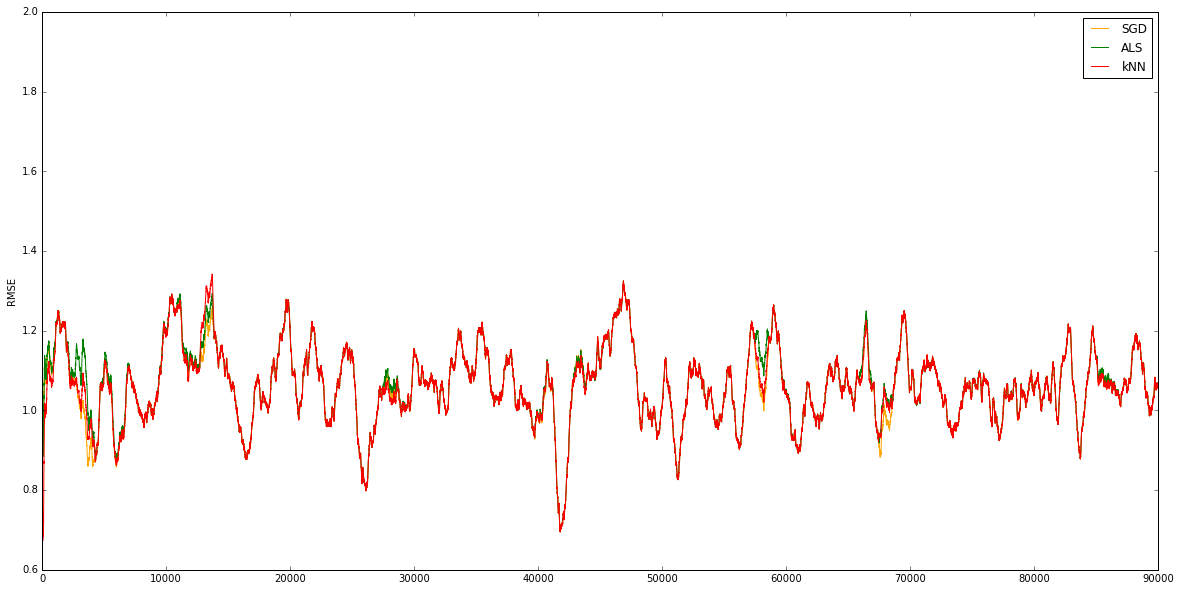

In [39]:
plt.figure(figsize=(20,10),dpi=300)

plt.plot(rmseAvg[:,0],color='orange', label='SGD')
plt.plot(rmseAvg[:,1],color='green', label='ALS')
plt.plot(rmseAvg[:,2],color='red', label='kNN')
plt.ylabel('RMSE')
plt.legend()

plt.show()

On this smaller dataset, the 3 algorithms seem to perform similarly in regards of RMSE.

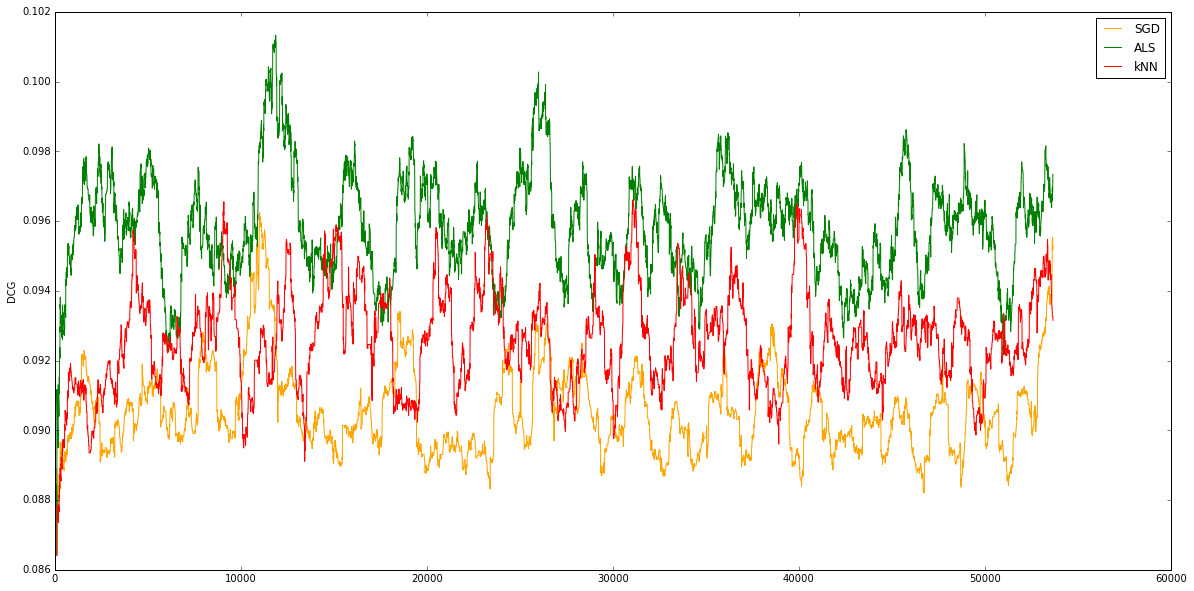

In [40]:
plt.figure(figsize=(20,10),dpi=300)

plt.plot(dcgFilteredAvg[:,0],color='orange', label='SGD')
plt.plot(dcgFilteredAvg[:,1],color='green', label='ALS')
plt.plot(dcgFilteredAvg[:,2],color='red', label='kNN')
plt.ylabel('DCG')
plt.legend()

plt.show()

There are greater differences for DCG. ALS has the highest values, while SGD has the lowest.

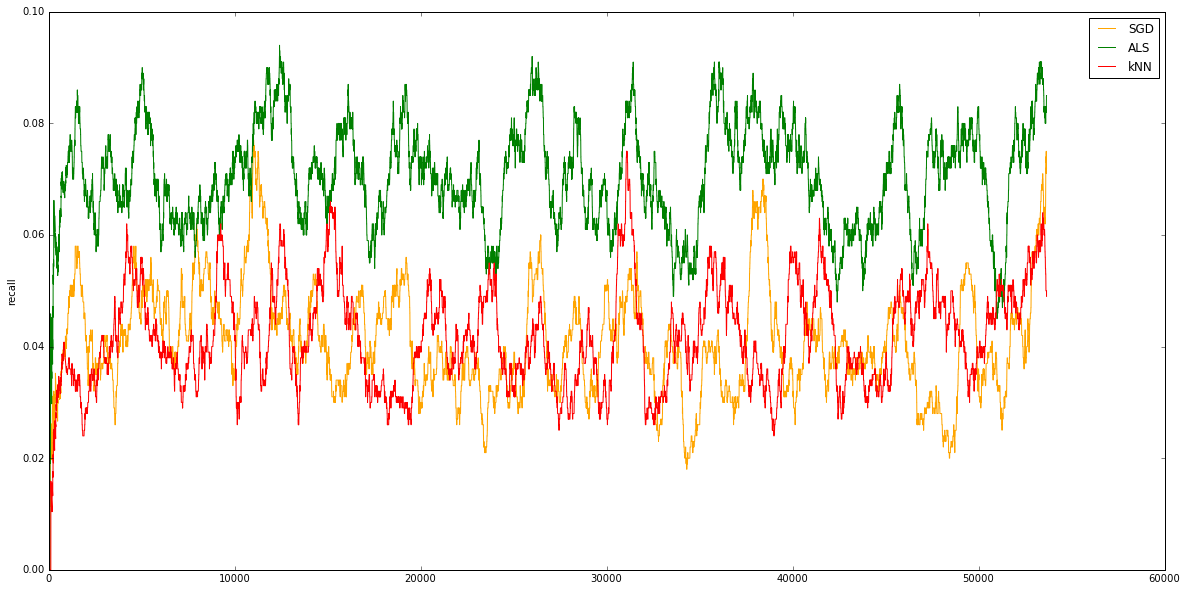

In [41]:
plt.figure(figsize=(20,10),dpi=300)

plt.plot(recallFilteredAvg[:,0],color='orange', label='SGD')
plt.plot(recallFilteredAvg[:,1],color='green', label='ALS')
plt.plot(recallFilteredAvg[:,2],color='red', label='kNN')
plt.ylabel('recall')
plt.legend()

plt.show()

ALS has the highest values for recall too, while the other two have similar performances.

### Item-to-item

Loading data from logs:

In [42]:
with open('log/jaccard.log') as f:
    jaccard = f.readlines()
    jaccard = [json.loads(x.strip('\n')) for x in jaccard]
    
with open('log/EIR.log') as f:
    eir = f.readlines()
    eir = [json.loads(x.strip('\n')) for x in eir]

Processing data:

In [43]:
mprFiltered = np.array([[jaccard[i]['mpr'],
                         eir[i]['mpr']] for i in range(len(jaccard))
                         if eir[i]['item_found'] and eir[i]['user_found']])

avgSize = 1000
mprFilteredT = mprFiltered.transpose()

mprFilteredAvg = np.array([[np.mean(mprFilteredT[0][max(i-avgSize+1,0):i+1]),
                            np.mean(mprFilteredT[1][max(i-avgSize+1,0):i+1])] 
                            for i in range(len(mprFiltered))])

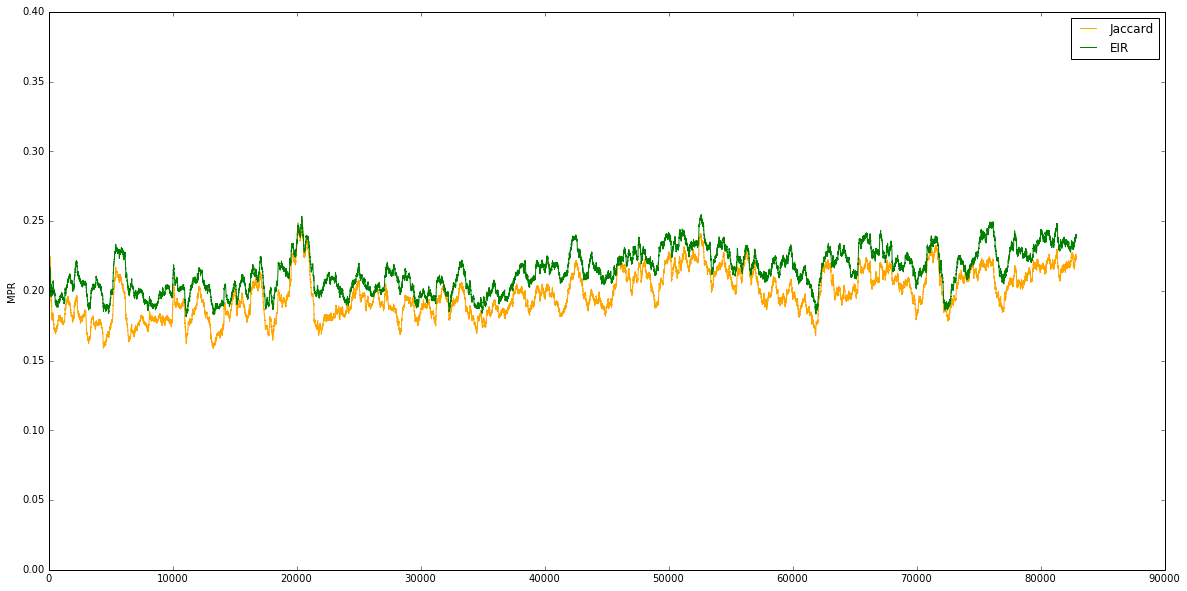

In [44]:
plt.figure(figsize=(20,10),dpi=300)

plt.plot(mprFilteredAvg[:,0],color='orange', label='Jaccard')
plt.plot(mprFilteredAvg[:,1],color='green', label='EIR')
plt.ylabel('MPR')
plt.legend()

plt.show()

The MPR for the two algorithms show the same results as it was seen in the thesis: Jaccard reached lower values constantly.